# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul </ul></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li>

## Подготовка

In [2]:
import pandas as pd
import seaborn as sns
import torch
import transformers as ppb
import spacy
import re
import numpy as np
import nltk
import pickle
import optuna
import lightgbm as lgb
from nltk.corpus import stopwords
from tqdm import notebook 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, make_scorer
import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv')

In [4]:
data.tail()

,Unnamed: 0,text,toxic
159287,159446,""":::::And for the second time of asking, when ...",0
159288,159447,You should be ashamed of yourself \n\nThat is ...,0
159289,159448,"Spitzer \n\nUmm, theres no actual article for ...",0
159290,159449,And it looks like it was actually you who put ...,0
159291,159450,"""\nAnd ... I really don't think you understand...",0


In [5]:
data['Unnamed: 0'].value_counts().sum()

159292

In [6]:
data['toxic'].value_counts()

0    143106
1     16186
Name: toxic, dtype: int64

<AxesSubplot: xlabel='toxic', ylabel='count'>

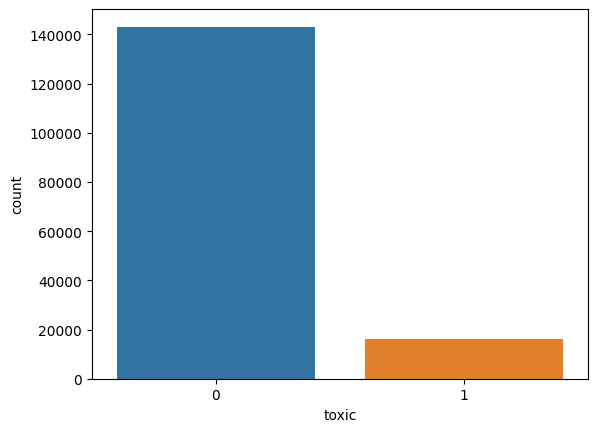

In [7]:
sns.countplot(x = 'toxic', data = data)

In [8]:
data.loc[data['Unnamed: 0']>data.index]

,Unnamed: 0,text,toxic
6080,6084,"""::I'll alos be looking in to see how this is ...",0
6081,6085,"""\n\nThe Ezekiel passage is quoted in the Molo...",0
6082,6086,Thank you for experimenting with Wikipedia. Y...,0
6083,6087,Any complaints with that as the new wording?,0
6084,6088,"""\nI also disagree with the merge as Strength ...",0
...,...,...,...
159287,159446,""":::::And for the second time of asking, when ...",0
159288,159447,You should be ashamed of yourself \n\nThat is ...,0
159289,159448,"Spitzer \n\nUmm, theres no actual article for ...",0
159290,159449,And it looks like it was actually you who put ...,0


In [9]:
data.loc[[6079]]

,Unnamed: 0,text,toxic
6079,6079,"Hrafn \n\nPM, Where did Hrafn go? There was a ...",0


In [10]:
data=data.drop('Unnamed: 0', axis=1)
data.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [12]:
parse = spacy.load('en_core_web_sm')

def normalize(s, exceptions={"PUNCT", "SPACE"}): 
    doc = parse(s)
    return " ".join([token.lemma_ for token in doc if token.pos_ not in exceptions])

In [13]:
def clear_text(text):
    clear_text = re.sub(r'[^a-zA-Z]', ' ', text).split()
    clear_text = " ".join(clear_text)
    return clear_text 

In [14]:
data["text"] = data["text"].apply(lambda t: (normalize(clear_text(t))))
data.head()

,text,toxic
0,Explanation why the edit make under my usernam...,0
1,D aww he match this background colour I m seem...,0
2,hey man I m really not try to edit war it s ju...,0
3,More I can t make any real suggestion on impro...,0
4,you sir be my hero any chance you remember wha...,0


Обработала текст

In [15]:
# Разделяю на признаки и целевой признак
features=data['text']
target=data['toxic']

In [16]:
# Разделяю на обучающую  и тестовую
features_train, features_test, target_train, target_test=train_test_split(
    features, target, test_size=0.3,random_state=19191)

In [17]:
nltk.download('stopwords')# загружаю стоп слова
stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Анна\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
count_tf_idf = TfidfVectorizer(stop_words=stopwords)

Таким образом, в наших данных представлены Текст и целевой признак - токсичные комментарии. В датасете 153212 строк, к сожалению, мои мощности не позволяют обработать его целиком, я выбрала 30000 строк. Выбранные данные были обработаны и переведены в векторный вид

## Обучение

#### LogisticRegression

In [21]:
pipeline = Pipeline(
    [
        ("vect", CountVectorizer(stop_words=stopwords)),
        ("tfidf", TfidfTransformer()),
        ("clf", LogisticRegression(class_weight='balanced',random_state=19191)),
    ]
)


parameters = {
    "vect__max_df": (0.3, 0.5),
    'vect__max_features': (None, 5000),
    "vect__ngram_range": ((1, 1), (1, 3)),
    "clf__max_iter": (40, 50, 60),
    'tfidf__norm': ('l2', None)
}

In [23]:
grid_search = GridSearchCV(pipeline, parameters, scoring="f1", n_jobs=-1, verbose=1)

print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline.steps])
print("parameters:")
print(parameters)

grid_search.fit(features_train, target_train)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters:
{'vect__max_df': (0.3, 0.5), 'vect__max_features': (None, 5000), 'vect__ngram_range': ((1, 1), (1, 3)), 'clf__max_iter': (40, 50, 60), 'tfidf__norm': ('l2', None)}
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best score: 0.778
Best parameters set:
	clf__max_iter: 40
	tfidf__norm: None
	vect__max_df: 0.3
	vect__max_features: None
	vect__ngram_range: (1, 3)


In [24]:
predictions_lr = grid_search.predict(features_test)

In [25]:
f1_score_lr = f1_score(target_test, predictions_lr)
f1_score_lr

0.7814614343707713

## Выводы

В моем распоряжении был набор данных с разметкой о токсичности правок. Я выбранные данные были обработаны и переведены в векторный вид для обучения моделей классификации комментариев на позитивные и негативные. 
Я сравнивала 3 модели: Logistic Regression, LGBMClassifier и CatBoostClassifier по метрике f1. Лучшей моделью стал Logistic Regression с показателем  0.781 на тестовой выборке